In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('jamb_exam_results.csv', delimiter=',')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,183,20,74,2,10.6,Public,Urban,Yes,No,Low,Low,4996,16,Male,Medium,Primary,2
4996,179,0,80,2,20.0,Public,Rural,No,Yes,Medium,Medium,4997,22,Male,Low,Secondary,1
4997,261,17,89,3,11.3,Public,Urban,No,No,Low,High,4998,18,Male,Medium,Primary,3
4998,183,15,96,2,15.9,Public,Rural,No,No,Low,Medium,4999,18,Male,Medium,Secondary,1


In [3]:
del df['student_id']

In [4]:
df = df.fillna(0)

In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']
del df_full_train['jamb_score']

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [7]:
train_dicts = df_train.to_dict(orient='records')
train_val = df_val.to_dict(orient='records')
train_test = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(train_val)
X_test = dv.transform(train_test)

features = dv.get_feature_names_out()

# Question 1

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [9]:
dt = DecisionTreeClassifier(max_depth = 1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [10]:
y_pred = dt.predict(X_val)

In [11]:
print(export_text(dt, feature_names = dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- class: 118
|--- study_hours_per_week >  18.50
|   |--- class: 190



# Question 2

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
y_pred = rf.predict(X_val)

In [15]:
def rmse(y,y_pred):
    error = (y-y_pred)**2
    mse = error.mean()
    return np.sqrt(mse)

In [16]:
rmse(y_pred, y_val)

42.13724207871227

# Question 3

In [129]:
score = []
step =[]
for i in range(10,201,10): 
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    
    rmses = rmse(y_pred, y_val)
    score.append(rmses)
    step.append(i)
    
    print('%4s -> %.3f' % (i, rmses))   

  10 -> 42.137
  20 -> 41.461
  30 -> 41.106
  40 -> 40.917
  50 -> 40.852
  60 -> 40.784
  70 -> 40.677
  80 -> 40.539
  90 -> 40.504
 100 -> 40.517
 110 -> 40.593
 120 -> 40.625
 130 -> 40.651
 140 -> 40.595
 150 -> 40.597
 160 -> 40.604
 170 -> 40.628
 180 -> 40.641
 190 -> 40.631
 200 -> 40.601


(40.5, 40.8)

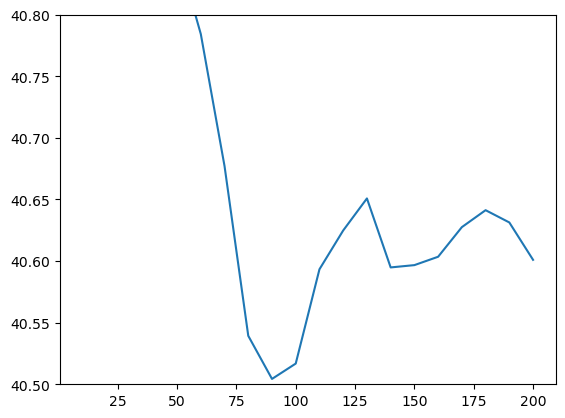

In [130]:
plt.plot(step, score)
plt.ylim([40.5, 40.8])

In [132]:
min(score)

40.50434592594835

# Question 4

In [134]:
results = []

for j in [10, 15, 20, 25] :
    rmses_mean = []
    for i in range(10,201,10): 
        rmses = []
        rf = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        rmses.append(rmse(y_pred, y_val))
    
    rmses_m = np.mean(rmses)
    rmses_mean.append(rmses_m)
    results.append((j, rmses_mean))

In [135]:
df_results = pd.DataFrame(results, columns=['max_depth', 'rmse_values'])
df_results = df_results.explode('rmse_values').reset_index(drop=True)

# Print final results
print("\nFinal Results (Mean RMSE for each max_depth and n_estimators combination):")
df_results


Final Results (Mean RMSE for each max_depth and n_estimators combination):


,max_depth,rmse_values
0,10,40.325012
1,15,40.543618
2,20,40.547698
3,25,40.598527


In [136]:
min(df_results['rmse_values'])

40.32501201024062

# Question 5

In [147]:
rf = RandomForestRegressor(n_estimators=10, max_depth = 20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_val)

feature_importance = rf.feature_importances_

importance = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

importance = importance.sort_values(by='Importance', ascending=False)
importance

,Feature,Importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311
3,assignments_completed,0.031517
24,socioeconomic_status=High,0.025714
17,parent_involvement=High,0.022919
10,it_knowledge=High,0.017719
15,parent_education_level=Secondary,0.016957


# Question 6

In [17]:
import xgboost as xgb

In [32]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [33]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [34]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [35]:
scores = {}

In [40]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [41]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [42]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

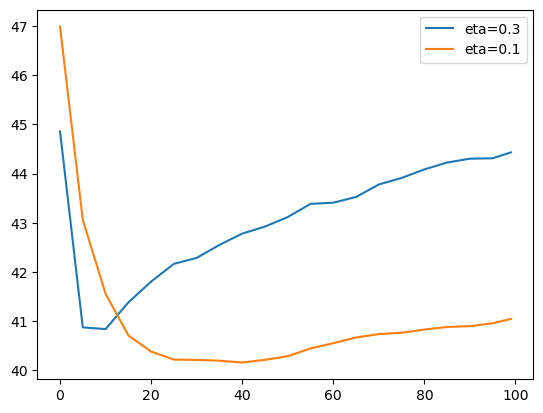

In [43]:
etas = ["eta=0.3", "eta=0.1"]

for eta in etas :
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()